## Orthogonality

Source code: Causal AI book (2024)

We compare the performance of the naive and orthogonal methods in a computational experiment where
$p=n=100$, $\beta_j = 1/j^2$, $(\gamma_{DW})_j = 1/j^2$ and $$Y = 1 \cdot D + \beta' W + \epsilon_Y$$

where $W \sim N(0,I)$, $\epsilon_Y \sim N(0,1)$, and $$D = \gamma'_{DW} W + \tilde{D}$$ where $\tilde{D} \sim N(0,1)/4$.

The true treatment effect here is 1. From the plots produced in this notebook (estimate minus ground truth), we show that the naive single-selection estimator is heavily biased (lack of Neyman orthogonality in its estimation strategy), while the orthogonal estimator based on partialling out, is approximately unbiased and Gaussian.

In [1]:
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

fatal: destination path 'hdmpy' already exists and is not an empty directory.


In [2]:
import random
import hdmpy
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Set seed
np.random.seed(1234)

In [4]:
# Initialize constants
B = 1000  # Number of iterations
n = 100  # Sample size
p = 100  # Number of features

# Sim Parameters
mean = 0
sd = 1

# Initialize arrays to store results
naive = np.zeros(B)
orthogonal = np.zeros(B)

# Iterate through B simulations
for i in tqdm(range(B)):

    # Generate parameters:
    gamma = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    beta = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)

    # Generate covariates / random data
    X = np.random.normal(mean, sd, n * p).reshape(n, p)
    D = (X @ gamma) + np.random.normal(mean, sd, n).reshape(n, 1) / 4

    # Generate Y using DGP
    Y = D + (X @ beta) + np.random.normal(mean, sd, n).reshape(n, 1)

    # Single selection method using rlasso
    r_lasso_estimation = hdmpy.rlasso(np.concatenate((D, X), axis=1), Y, post=True)
    coef_array = r_lasso_estimation.est['coefficients'].iloc[2:, :].to_numpy()
    SX_IDs = np.where(coef_array != 0)[0]

    # Check if any X coefficients are selected
    if sum(SX_IDs) == 0:
        # If no X coefficients are selected, regress Y on D only
        naive[i] = sm.OLS(Y, sm.add_constant(D)).fit().params[1]
    else:
        # If X coefficients are selected, regress Y on selected X and D
        X_D = np.concatenate((D, X[:, SX_IDs]), axis=1)
        naive[i] = sm.OLS(Y, sm.add_constant(X_D)).fit().params[1]

    # Double Lasso Partialling Out
    resY = hdmpy.rlasso(X, Y, post=False).est['residuals']
    resD = hdmpy.rlasso(X, D, post=False).est['residuals']
    orthogonal[i] = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [10:54<00:00,  1.53it/s]


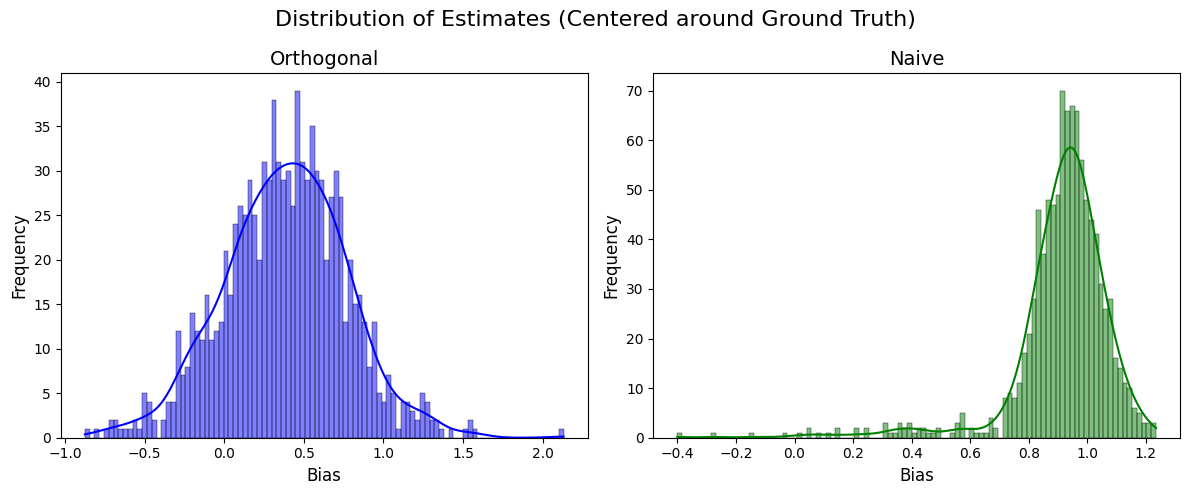

In [13]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bias_orthogonal = orthogonal - 1
bias_naive = naive - 1

# Plot a histogram for the 'Naive' estimates vector
sns.histplot(bias_naive, bins=100, kde=True, color='green', ax=axes[1])
axes[1].set_title('Naive', fontsize=14)
axes[1].set_xlabel('Bias', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Plot a histogram for the 'Orthogonal' estimates vector
sns.histplot(bias_orthogonal, bins=100, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Orthogonal', fontsize=14)
axes[0].set_xlabel('Bias', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Add a title to the entire figure
fig.suptitle('Distribution of Estimates (Centered around Ground Truth)', fontsize=16)

# Display the histograms side by side
plt.tight_layout()
plt.show()

In [6]:
print(f'The Avg Bias of Orthogonal estimator is: {bias_orthogonal.mean()}')
print(f'The Avg Bias of Orthogonal estimator is: {bias_naive.mean()}')

The Avg Bias of Orthogonal estimator is: 0.38433697249687604
The Avg Bias of Orthogonal estimator is: 0.9118538045013813
